In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,GlobalMaxPooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import re,string,nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df2=pd.read_csv('data/Twitter_Data.csv')
df1=pd.read_csv('data/Reddit_Data.csv')

In [3]:
df1['category'].unique()

array([ 1, -1,  0], dtype=int64)

In [4]:
df2['category'].unique()

array([-1.,  0.,  1., nan])

In [5]:
df2.columns=['messages','labels']
df1.columns=['messages','labels']

In [6]:
df1.head()

,messages,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


df1['labels']=df1['labels'].map({-1:0,0:1,1:2})

In [7]:
df=pd.concat([df1,df2],ignore_index=True)

In [8]:
df['labels']=df['labels'].map({-1:0,0:1.0,1:2.0})

In [9]:
df['messages'].iloc[0] #iloc is used to select a row

' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches '

In [10]:
df['messages'].iloc[100]

' want move gujarat and live there for few months any city that you can recommend '

In [11]:
df.head()

,messages,labels
0,family mormon have never tried explain them t...,2.0
1,buddhism has very much lot compatible with chr...,2.0
2,seriously don say thing first all they won get...,0.0
3,what you have learned yours and only yours wha...,1.0
4,for your own benefit you may want read living ...,2.0


In [12]:
df.tail()

,messages,labels
200224,why these 456 crores paid neerav modi not reco...,0.0
200225,dear rss terrorist payal gawar what about modi...,0.0
200226,did you cover her interaction forum where she ...,1.0
200227,there big project came into india modi dream p...,1.0
200228,have you ever listen about like gurukul where ...,2.0


def text_process(mess):
    nopunc = str(mess).lower()
    nopunc=[word for word in nopunc if word not in string.punctuation]
    nopunc=''.join(nopunc)
    nopunc=[word for word in nopunc if word.lower() not in stopwords.words('english')]
    return [stemmer.stem(word) for word in nopunc]

df1['messages']=df1['messages'].apply(text_process)

<AxesSubplot: ylabel='Frequency'>

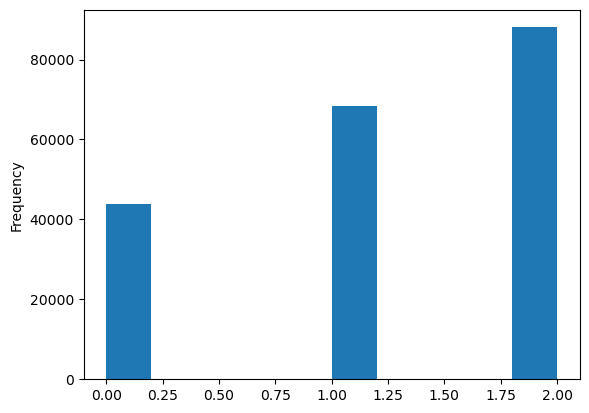

In [13]:
df['labels'].plot(kind='hist')

In [14]:
df['length']=df['messages'].str.len()

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
labels,200222.0,1.221219,0.780813,0.0,1.0,1.0,2.0,2.0
length,200125.0,134.796737,167.639234,1.0,61.0,109.0,183.0,8665.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   messages  200125 non-null  object 
 1   labels    200222 non-null  float64
 2   length    200125 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.6+ MB


In [17]:
df.head()

,messages,labels,length
0,family mormon have never tried explain them t...,2.0,261.0
1,buddhism has very much lot compatible with chr...,2.0,1269.0
2,seriously don say thing first all they won get...,0.0,460.0
3,what you have learned yours and only yours wha...,1.0,168.0
4,for your own benefit you may want read living ...,2.0,691.0


In [18]:
df[df['length']==8665]['messages'].iloc[0]

'brilliant point point breakdown one other argument making the rounds false argument okay maybe the strikes took place but should have been kept secret and deniable there good reason for dgmo make statements about covert actions except for bjp score political points there are massive number reasons make strike like this public exposes pakistan bluster just tough talk for all their talk being high alert for indian troop movement along the loc after the uri attack they didn even see coming massively boosts morale within the armed forces morale which has been getting steadily lower our bases kept getting hit while they were not allowed take charge the offensive the troops are also being vilified the media national and international while trying control spiral violence srinagar fueled pakistan propaganda machine makes the best use pakistan blunder overreaching and outmaneuvers them pakistan has its hands tied now after making bold statements about defending against indian adventurism aggre

In [19]:
df.isnull().sum()

messages    104
labels        7
length      104
dtype: int64

In [20]:
df=df.dropna()

In [21]:
df['messages']

0          family mormon have never tried explain them t...
1         buddhism has very much lot compatible with chr...
2         seriously don say thing first all they won get...
3         what you have learned yours and only yours wha...
4         for your own benefit you may want read living ...
                                ...                        
200224    why these 456 crores paid neerav modi not reco...
200225    dear rss terrorist payal gawar what about modi...
200226    did you cover her interaction forum where she ...
200227    there big project came into india modi dream p...
200228    have you ever listen about like gurukul where ...
Name: messages, Length: 200118, dtype: object

In [22]:
len(df1['messages'])

37249

In [23]:
import re
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)
def remove_html(text):
    return re.sub('<.*?>','',text)
def replace_mentions(text):
    return re.sub('@\S*','user',text)
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)
def replace_heart(text):
    return re.sub('<3','HEART', text)
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text
def stemming(text):
    stemmer=PorterStemmer()
    text=' '.join([stemmer.stem(word) for word in text.split()])
    return text
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [24]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text = stemming(text)
    text=lemmatization(text)
    return text

In [25]:
df['messages1']=df['messages'].apply(clean_text)

In [26]:
df

,messages,labels,length,messages1
0,family mormon have never tried explain them t...,2.0,261.0,family mormon never try explain still stare pu...
1,buddhism has very much lot compatible with chr...,2.0,1269.0,buddhism much lot compatible christianity espe...
2,seriously don say thing first all they won get...,0.0,460.0,seriously say thing first get complex explain ...
3,what you have learned yours and only yours wha...,1.0,168.0,learn want teach different focus goal wrap pap...
4,for your own benefit you may want read living ...,2.0,691.0,benefit may want read live buddha live christ ...
...,...,...,...,...
200224,why these 456 crores paid neerav modi not reco...,0.0,108.0,crores pay neerav modi recover congress leader...
200225,dear rss terrorist payal gawar what about modi...,0.0,248.0,dear rss terrorist payal gawar modi kill plus ...
200226,did you cover her interaction forum where she ...,1.0,51.0,cover interaction forum leave
200227,there big project came into india modi dream p...,1.0,77.0,big project come india modi dream project happ...


In [27]:
X=df['messages1']
y=df['labels']
print(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

0         2.0
1         2.0
2         0.0
3         1.0
4         2.0
         ... 
200224    0.0
200225    0.0
200226    1.0
200227    1.0
200228    2.0
Name: labels, Length: 200118, dtype: float64


In [28]:
X_train.shape

(134079,)

In [29]:
Max_vocab_size=50000
tokenizer=Tokenizer(num_words=Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain=tokenizer.texts_to_sequences(X_train)
sequence_Xtest=tokenizer.texts_to_sequences(X_test)

In [30]:
V=len(tokenizer.word_index)

In [32]:
data_train=pad_sequences(sequence_Xtrain)

In [33]:
T=data_train.shape[1]
print(T)

864


In [34]:
data_test=pad_sequences(sequence_Xtest,maxlen=T)

In [35]:
data_train.shape

(134079, 864)

In [36]:
y_train.shape

(134079,)

In [37]:
data_test.shape

(66039, 864)

In [38]:
y_test.shape

(66039,)

In [39]:
y_train.shape

(134079,)

In [40]:
y_train.unique()

array([1., 2., 0.])

In [41]:
y.shape

(200118,)

In [42]:
D=20
i=Input(shape=(T,))
x=Embedding(V+1,D)(i)
x=LSTM(128,dropout=(0.2))(x)
x=Dense(3,activation='softmax')(x)
model=Model(i,x)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(data_train,y_train,batch_size=128,validation_data=(data_test,y_test),epochs=10)

Epoch 1/10
1048/1048 [==============================] - 106s 95ms/step - loss: 0.5496 - accuracy: 0.7818 - val_loss: 0.3722 - val_accuracy: 0.8754
Epoch 2/10
1048/1048 [==============================] - 98s 94ms/step - loss: 0.3333 - accuracy: 0.8850 - val_loss: 0.3500 - val_accuracy: 0.8824
Epoch 3/10
1048/1048 [==============================] - 99s 95ms/step - loss: 0.2928 - accuracy: 0.9001 - val_loss: 0.3575 - val_accuracy: 0.8798
Epoch 4/10
1048/1048 [==============================] - 99s 95ms/step - loss: 0.2638 - accuracy: 0.9108 - val_loss: 0.3698 - val_accuracy: 0.8766
Epoch 5/10
1048/1048 [==============================] - 99s 95ms/step - loss: 0.2406 - accuracy: 0.9194 - val_loss: 0.3902 - val_accuracy: 0.8703
Epoch 6/10
1048/1048 [==============================] - 98s 93ms/step - loss: 0.2223 - accuracy: 0.9251 - val_loss: 0.4089 - val_accuracy: 0.8677
Epoch 7/10
1048/1048 [==============================] - 97s 92ms/step - loss: 0.2039 - accuracy: 0.9317 - val_loss: 0.4202 

In [43]:
model.evaluate(data_test,y_test)

2064/2064 [==============================] - 62s 30ms/step - loss: 0.4911 - accuracy: 0.8576


[0.4910750091075897, 0.8575841784477234]

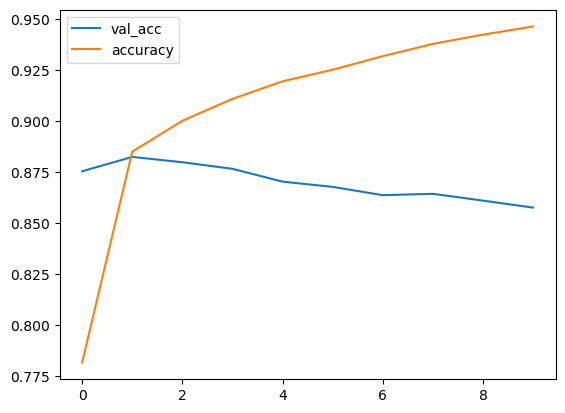

In [44]:
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()

<AxesSubplot: >

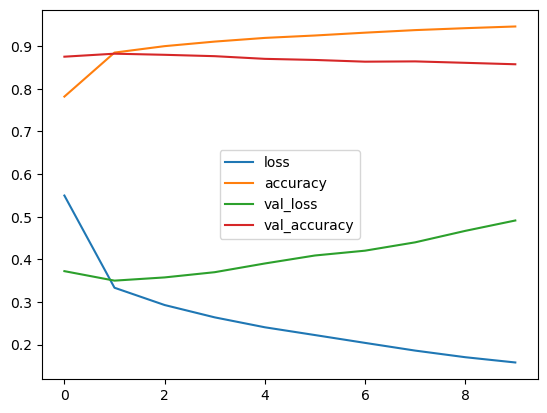

In [45]:
losses=pd.DataFrame(history.history)
losses.plot()

In [46]:
predictions=model.predict(data_test).argmax(axis=1)

2064/2064 [==============================] - 64s 31ms/step


In [47]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     14502
         1.0       0.88      0.88      0.88     22644
         2.0       0.88      0.87      0.87     28893

    accuracy                           0.86     66039
   macro avg       0.85      0.85      0.85     66039
weighted avg       0.86      0.86      0.86     66039



Text(50.722222222222214, 0.5, 'true_labels')

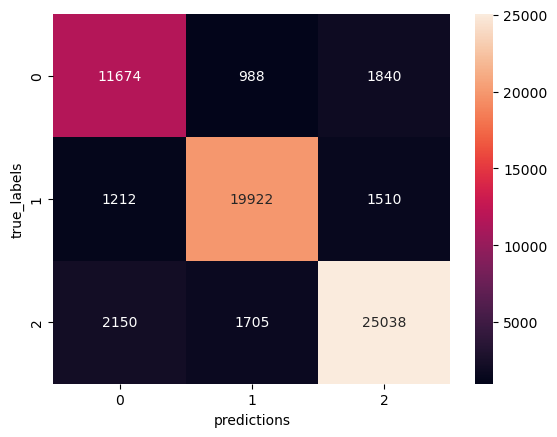

In [48]:
import tensorflow as tf
cm=tf.math.confusion_matrix(y_test,predictions)
sns.heatmap(cm,fmt='d',annot=True)
plt.xlabel('predictions')
plt.ylabel('true_labels')

In [49]:
model.save('model1.h5')